<a href="https://www.kaggle.com/code/akscent/feature-extraction-classifer-txt?scriptVersionId=149419169" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:

!pip install pymorphy2 cleantext -U nlp_profiler textblob pymystem3 > installer_log.txt
import os
import sys
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sys.path.insert(1, '/kaggle/input/ods-huawei/nlp_huawei_new2_task-master/nlp_huawei_new2_task-master/baseline_transformers')
# from dataset import *
# from model import *
# from trainer import Trainer

import torch
from torch.utils.data import Dataset
from typing import Dict
import json
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW
from tqdm.notebook import tqdm
from textblob import TextBlob

torch.manual_seed(42)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class FiveDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_seq_len):
        self.data = dataframe
        self.text = dataframe['text'].tolist()
        self.targets = None
        if 'rate' in dataframe:
            self.targets = dataframe['rate'].tolist()
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.long)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
            }

    def __len__(self) -> int:
        return len(self.text)
    

class ModelForClassification(torch.nn.Module):

    def __init__(self, model_path: str, config: Dict):
        super(ModelForClassification, self).__init__()
        self.model_name = model_path
        self.config = config
        self.n_classes = config['num_classes']
        self.dropout_rate = config['dropout_rate']
        self.bert = AutoModel.from_pretrained(self.model_name)
        self.pre_classifier = torch.nn.Linear(312, 768)
        self.dropout = torch.nn.Dropout(self.dropout_rate)
        self.classifier = torch.nn.Linear(768, self.n_classes)
        self.softmax = torch.nn.LogSoftmax(dim = 1)

    def forward(self, input_ids, attention_mask,):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        hidden_state = output[0]
        hidden_state = hidden_state[:, 0]
        hidden_state = self.pre_classifier(hidden_state)
        hidden_state = torch.nn.ReLU()(hidden_state)
        hidden_state = self.dropout(hidden_state)
        output = self.classifier(hidden_state)
        output = self.softmax(output)
        return output


class Trainer:
    def __init__(self, config: Dict, class_weights=None):
        self.config = config
        self.device = config['device']
        self.n_epochs = config['n_epochs']
        self.optimizer = None
        self.opt_fn = lambda model: AdamW(model.parameters(), config['lr'])
        self.model = None
        self.history = None
        if class_weights is not None:
            class_weights = class_weights.to(self.device)
            self.loss_fn = CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = CrossEntropyLoss()
        self.device = config['device']
        self.verbose = config.get('verbose', True)
        
    def save_history(self, path: str):
        history = {
            'train_loss': self.history['train_loss'],
            'val_loss': self.history['val_loss'],
            'val_acc': self.history['val_acc']
        }
        val_acc = sum(self.history['val_acc']) / len(self.history['val_acc'])
        print("All ACCURACY = ", val_acc)
        with open(path, 'w') as file:
            json.dump(history, file)
        
    def load_history(self, path: str):
        with open(path, 'r') as file:
            history = json.load(file)
        self.history = {
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'val_acc': history['val_acc']
        }

    def fit(self, model, train_dataloader, val_dataloader):
        self.model = model.to(self.device)
        self.optimizer = self.opt_fn(model)
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }
        best_val_loss = float('inf')

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self.train_epoch(train_dataloader)
            val_info = self.val_epoch(val_dataloader)
            self.history['train_loss'].extend(train_info['loss'])
            self.history['val_loss'].extend([val_info['loss']])
            self.history['val_acc'].extend([val_info['acc']])

            if val_info['loss'] < best_val_loss:
                best_val_loss = val_info['loss']
                self.save_model_weights('best_model_weights.ckpt')

            self.save_history('history.json')

        return self.model.eval()

    def save_model_weights(self, path: str):
        torch.save(self.model.state_dict(), path)



    def train_epoch(self, train_dataloader):
        self.model.train()
        losses = []
        total_loss = 0
        if self.verbose:
            train_dataloader = tqdm(train_dataloader)
        for batch in train_dataloader:
            ids = batch['ids'].to(self.device, dtype=torch.long)
            mask = batch['mask'].to(self.device, dtype=torch.long)
            targets = batch['targets'].to(self.device, dtype=torch.long)

            outputs = self.model(ids, mask)
            loss = self.loss_fn(outputs, targets)
            total_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_val = loss.item()
            if self.verbose:
                train_dataloader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
        avg_loss = total_loss / len(train_dataloader)
        print("AVG LOSS = ", avg_loss)
        return {'loss': losses}

    def val_epoch(self, val_dataloader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_dataloader = tqdm(val_dataloader)
        with torch.no_grad():
            for batch in val_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                targets = batch['targets'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                all_logits.append(outputs)
                all_labels.append(targets)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits).to(self.device)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        print("ACCURACY for EPOCH = ", acc)
        if self.verbose:
            val_dataloader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {
            'acc': acc,
            'loss': loss
        }

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                preds = torch.exp(outputs)
                predictions.extend(preds.tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

    def plot_history(self):
        import matplotlib.pyplot as plt
        
        if self.history is None:
            raise RuntimeError("History is not available. Train the model first.")

        train_loss = self.history['train_loss']
        val_loss = self.history['val_loss']
        val_acc = self.history['val_acc']

        epochs = range(1, len(train_loss) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "model_state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = ModelForClassification(
            ckpt['model_name'],
            ckpt["config"]
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer

# Data load

In [17]:
PATH = "/kaggle/input/ods-huawei/"
train_data = pd.read_csv(os.path.join(PATH, "train.csv"))
test_data = pd.read_csv(os.path.join(PATH, "test.csv"))
le = LabelEncoder()
train_data.rate = le.fit_transform(train_data.rate)
train_data.head()

,rate,text
0,3,Очень понравилось. Были в начале марта с соба...
1,4,В целом магазин устраивает.\nАссортимент позво...
2,4,"Очень хорошо что открылась 5 ка, теперь не над..."
3,2,Пятёрочка громко объявила о том как она заботи...
4,2,"Тесно, вечная сутолока, между рядами трудно ра..."


# Pre-clean text

In [18]:
# import re
# TOKEN_RE = re.compile(r'[а-яё]+')

# def tokenize_text(text, min_length_token=1):
#     text = text.lower()
#     tokens = TOKEN_RE.findall(text)
#     return [token for token in tokens if len(token) >= min_length_token]

# def text_cleaning(text):
#     tokens = tokenize_text(text)
#     return ' '.join(tokens)

# tqdm.pandas()
# train_data['text'] = train_data['text'].progress_apply(text_cleaning)
# test_data['text'] = test_data['text'].progress_apply(text_cleaning)

import re
import pymorphy2

from nltk.corpus import stopwords

ru_stopwords = stopwords.words('russian')
digits = [str(i) for i in range(10)]

TOKEN_RE = re.compile(r'[а-яё!.,?%]+')
lemmatizer = pymorphy2.MorphAnalyzer()

def is_valid_word(word):
    if not word[0].isdigit() and word not in ru_stopwords:
        parsed_word = lemmatizer.normal_forms(word)[0]
        return parsed_word
    return False

def text_cleaning(text):
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    words = text.split()
    cleaned_words = [word for word in words[:512] if is_valid_word(word) and len(word) < 15]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

tqdm.pandas()
train_data['text'] = train_data['text'].progress_apply(text_cleaning)
test_data['text'] = test_data['text'].progress_apply(text_cleaning)

train_data["num_words"] = train_data["text"].apply(
    lambda x: len(str(x).split()))
test_data["num_words"] = test_data["text"].apply(
    lambda x: len(str(x).split()))

  0%|          | 0/48665 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# train_data.to_csv("cleaned_train.csv", index=False)
# test_data.to_csv("cleaned_test.csv", index=False)

In [ ]:
# del zero
train_data = train_data[train_data['num_words'] != 0]
test_data = test_data[test_data['num_words'] != 0]

In [ ]:
from collections import Counter

def remove_infrequent_words(dataset, min_count=3):
    word_counter = Counter()
    for text in dataset:
        words = text.split()
        word_counter.update(words)
    infrequent_words = [word for word, count in word_counter.items() if count < min_count]
    def remove_infrequent(text):
        words = text.split()
        cleaned_words = [word for word in words if word not in infrequent_words]
        cleaned_text = ' '.join(cleaned_words)
        return cleaned_text
    cleaned_dataset = [remove_infrequent(text) for text in tqdm(dataset, desc="Cleaning text")]

    return cleaned_dataset

cleaned_train = remove_infrequent_words(train_data['text'].tolist())
cleaned_test = remove_infrequent_words(test_data['text'].tolist())


In [ ]:
train_data['cleaned_text'] = cleaned_train
test_data['cleaned_text'] = cleaned_test
train_data.to_csv("cleaned_train.csv", index=False)
test_data.to_csv("cleaned_test.csv", index=False)

# New data

In [ ]:
PATH = "/kaggle/input/cleaned-text"
train_data = pd.read_csv(os.path.join(PATH, "cleaned_train (1).csv"))
test_data = pd.read_csv(os.path.join(PATH, "cleaned_test (1).csv"))
# del zero
train_data = train_data[train_data['num_words'] != 0]
test_data = test_data[test_data['num_words'] != 0]
train_data.head()

In [ ]:
# replace nan

def replace_nan_with_text(row):
    if pd.isna(row['cleaned_text']):
        return row['text']
    return row['cleaned_text']

train_data['cleaned_text'] = train_data.progress_apply(replace_nan_with_text, axis=1)
test_data['cleaned_text'] = test_data.progress_apply(replace_nan_with_text, axis=1)

In [ ]:
def truncate_text(text, max_words=512):
    words = text.split()
    if len(words) > max_words:
        truncated_text = ' '.join(words[:max_words])
    else:
        truncated_text = text
    return truncated_text

tqdm.pandas()
train_data['cleaned_text'] = train_data['cleaned_text'].progress_apply(truncate_text)
test_data['cleaned_text'] = test_data['cleaned_text'].progress_apply(truncate_text)

In [ ]:
# идея суммирования текста в более короткий текст


from transformers import MBartTokenizer, MBartForConditionalGeneration

model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

def summary_rows(article_text):
    input_ids = tokenizer(
        [article_text],
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"]

    output_ids = model.generate(
        input_ids=input_ids,
        no_repeat_ngram_size=4
    )[0]

    summary = tokenizer.decode(output_ids, skip_special_tokens=True)
    return summary

def text_summary(text):
    if isinstance(text, str) and text.strip() and len(str(text).split()) > 150:
        return summary_rows(text)
    else:
        return text
    

train_data['summary'] = train_data['cleaned_text'].progress_apply(text_summary)
test_data['summary'] = test_data['cleaned_text'].progress_apply(text_summary)

In [ ]:
train_data

In [ ]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
from tqdm.notebook import tqdm

model = AutoModelForSequenceClassification.from_pretrained("apanc/russian-sensitive-topics")
tokenizer = AutoTokenizer.from_pretrained("apanc/russian-sensitive-topics")
tokenizer.padding = True
tokenizer.truncation = True
tokenizer.max_length = 512
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=torch.device("cuda:0"))

def make_pipe(text):
    return pipe(text, return_all_scores=True)

tqdm.pandas()
train_data['theme_labels'] = train_data['summary'].progress_apply(make_pipe)


In [ ]:
def extract_label_probs(row):
    label_probs = [label['score'] for label in row[0]]
    return label_probs

train_data['label_probs'] = train_data['theme_labels'].apply(extract_label_probs)

train_data = pd.concat([train_data, train_data['label_probs'].apply(pd.Series).add_prefix('LABEL_')], axis=1)

del train_data['label_probs']
del train_data['theme_labels']

In [ ]:
# feature data
train_data.to_csv("feature_train.csv", index=False)

In [ ]:
# # добавление переменных о чувствах
# from transformers import BertTokenizer, BertForSequenceClassification
# model_name = 'Skoltech/russian-sensitive-topics'
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertForSequenceClassification.from_pretrained(model_name);

# tokenized = tokenizer.batch_encode_plus(train_data[train_data["num_words"] > 80]['text'][370],
#                                         max_length = 512,
#                                         pad_to_max_length=True,
#                                         truncation=True,
#                                         return_token_type_ids=False)

# tokens_ids,mask = torch.tensor(tokenized['input_ids']),torch.tensor(tokenized['attention_mask']) 

# with torch.no_grad():
#     model_output = model(tokens_ids,mask)

# def adjust_multilabel(y, is_pred = False):
#     y_adjusted = []
#     for y_c in y:
#         y_test_curr = [0]*19
#         index = str(int(np.argmax(y_c)))
#         y_c = target_vaiables_id2topic_dict[index]
#     return y_c

# model_output

In [ ]:
# тональность текста
pipe = pipeline(model="seara/rubert-tiny2-russian-sentiment", device=torch.device("cuda:0"))

tqdm.pandas()
train_data['mood'] = train_data['summary'].progress_apply(make_pipe)

In [ ]:
train_data['label_probs'] = train_data['mood'].apply(extract_label_probs)

train_data = pd.concat([train_data, train_data['label_probs'].progress_apply(pd.Series).add_prefix('MOOD_')], axis=1)

del train_data['label_probs']
del train_data['mood']

In [ ]:
# feature data
train_data.to_csv("feature_train.csv", index=False)

In [ ]:
# токичность
from transformers import BertTokenizer, BertForSequenceClassification

# tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
# model = BertForSequenceClassification.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
# batch = tokenizer.encode(train_data[train_data["num_words"] > 80]['text'][48421], return_tensors='pt')
# model(batch)

pipe = pipeline(model="SkolkovoInstitute/russian_toxicity_classifier", device=torch.device("cuda:0"))

tqdm.pandas()
train_data['toxic'] = train_data['summary'].progress_apply(make_pipe)

In [ ]:
train_data['label_probs'] = train_data['toxic'].apply(extract_label_probs)

train_data = pd.concat([train_data, train_data['label_probs'].progress_apply(pd.Series).add_prefix('TOXIC_')], axis=1)

del train_data['label_probs']
del train_data['toxic']

In [ ]:
# эмоции
import torch
from transformers import BertForSequenceClassification, AutoTokenizer

LABELS = ['neutral', 'happiness', 'sadness', 'enthusiasm', 'fear', 'anger', 'disgust']
tokenizer = AutoTokenizer.from_pretrained('Aniemore/rubert-tiny2-russian-emotion-detection')
model = BertForSequenceClassification.from_pretrained('Aniemore/rubert-tiny2-russian-emotion-detection')

@torch.no_grad()
def predict_emotion(text: str) -> str:
    """
        We take the input text, tokenize it, pass it through the model, and then return the predicted label
        :param text: The text to be classified
        :type text: str
        :return: The predicted emotion
    """
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).numpy()
        
    return LABELS[predicted[0]]

@torch.no_grad()    
def predict_emotions(text: str) -> list:
    """
        It takes a string of text, tokenizes it, feeds it to the model, and returns a dictionary of emotions and their
        probabilities
        :param text: The text you want to classify
        :type text: str
        :return: A dictionary of emotions and their probabilities.
    """
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    emotions_list = {}
    for i in range(len(predicted.numpy()[0].tolist())):
        emotions_list[LABELS[i]] = predicted.numpy()[0].tolist()[i]
    return emotions_list

train_data['toxic'] = train_data['summary'].progress_apply(predict_emotions)

In [ ]:
train_data['toxic'][0]

In [ ]:
def extract_label_probs(row):
    label_probs = [row.get(label, 0.0) for label in LABELS]
    return label_probs

train_data['label_probs'] = train_data['toxic'].apply(extract_label_probs)

train_data = pd.concat([train_data, train_data['label_probs'].progress_apply(pd.Series).add_prefix('EMOTION_')], axis=1)

del train_data['label_probs']
del train_data['toxic']

In [ ]:
# feature data
train_data.to_csv("feature_train.csv", index=False)

# the end poka

In [3]:
PATH = "/kaggle/input/ods-huawei/"
train_data = pd.read_csv(os.path.join(PATH, "feature_train.csv"))

In [4]:
train_data["num_words_sum"] = train_data["summary"].apply(
    lambda x: len(str(x).split()))

In [5]:
max(train_data["num_words_sum"])

146

In [ ]:
# ! textblob - обработка текста, генерация фич https://textblob.readthedocs.io/en/dev/quickstart.html - ничего интересного
# ! еще одна библиотека для классификации текстов https://small-text.readthedocs.io/en/latest/ не подходит? для малкеньких текстов
# ! полярность слов https://polyglot.readthedocs.io/en/latest/ - тоже? что уже получил из предобученных моделей
# ! обработка фич https://github.com/jbesomi/texthero - плохо поддерживается
# фичегенерация https://github.com/neomatrix369/nlp_profiler#Notebooks
# классификация на других предобученных моделях, перечисленных у Алерона https://github.com/a-milenkin/Competitive_Data_Science/blob/main/notebooks/9.2.1%20-%20Text_Embeddings.ipynb
# использовать эти ноутбуки для классификации https://github.com/e0xextazy/vkcup2022-first-stage/blob/main/inference.ipynb

# Small Text Classifer

In [6]:
# !pip install small_text > installer_log.txt

In [8]:
# from transformers import AutoTokenizer
# from small_text import TransformersDataset

# num_classes = np.unique(train_data['rate']).shape[0]
# target_labels = np.arange(num_classes)

# train_split, val_split = train_test_split(train_data, test_size=0.15, random_state=42, 
#                                           shuffle = True, stratify=train_data['rate'])
# train_split = train_split.reset_index()
# val_split = val_split.reset_index()

# transformer_model_name = 'ai-forever/ruBert-base'

# tokenizer = AutoTokenizer.from_pretrained(
#     transformer_model_name
# )

# train = TransformersDataset.from_arrays(train_split['text'],
#                                         train_split['rate'],
#                                         tokenizer,
#                                         max_length=150,
#                                         target_labels=target_labels)
# test = TransformersDataset.from_arrays(val_split['text'],
#                                        val_split['rate'],
#                                        tokenizer,
#                                        max_length=150,
#                                        target_labels=target_labels)

/opt/conda/lib/python3.10/site-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '


# Active Learning

In [11]:

# sentence_transformer_model_name = 'cointegrated/rubert-tiny2'

# from small_text import (
#     PoolBasedActiveLearner,
#     PredictionEntropy,
#     TransformerBasedClassificationFactory,
#     TransformerModelArguments,
#     random_initialization_balanced
# )


# def initialize_active_learner(active_learner, y_train):

#     indices_initial = random_initialization_balanced(y_train, n_samples=100)
#     active_learner.initialize_data(indices_initial, y_train[indices_initial])

#     return indices_initial

# transformer_model = TransformerModelArguments(transformer_model_name)
# clf_factory = TransformerBasedClassificationFactory(transformer_model, 
#                                                     num_classes, 
#                                                     kwargs=dict({'device': 'cuda', 
#                                                                  'mini_batch_size': 32,
#                                                                  'class_weight': 'balanced'
#                                                                 }))
# query_strategy = PredictionEntropy()
# active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
# indices_labeled = initialize_active_learner(active_learner, train.y)

# Active Learning Loop

In [ ]:
# from sklearn.metrics import accuracy_score
# from small_text import KappaAverage


# num_queries = 20
# stopping_criterion = KappaAverage(num_classes, kappa=0.99)


# def evaluate(active_learner, train, test):
#     y_pred = active_learner.classifier.predict(train)
#     y_pred_test = active_learner.classifier.predict(test)
#     train_acc = accuracy_score(y_pred, train.y)

#     print('Train accuracy: {:.2f}'.format(train_acc))
#     print('Test accuracy: {:.2f}'.format(accuracy_score(y_pred_test, test.y)))
    
#     return train_acc


# results = []
# stopping_history = []

# results.append(evaluate(active_learner, train[indices_labeled], test))
# stopping_history.append(stopping_criterion.stop(predictions=active_learner.classifier.predict(train)))


# for i in range(num_queries):
#     indices_queried = active_learner.query(num_samples=50)
#     y = train.y[indices_queried]
#     active_learner.update(y)
#     indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
#     print('---------------')
#     print(f'Iteration #{i} ({len(indices_labeled)} samples)')
#     results.append(evaluate(active_learner, train[indices_labeled], test))
    
#     stopping_criterion_response = stopping_criterion.stop(predictions=active_learner.classifier.predict(train))
#     print(f'Stop: {stopping_criterion_response}')
#     stopping_history.append(stopping_criterion_response)

Train accuracy: 0.84
Test accuracy: 0.32
---------------
Iteration #0 (150 samples)
Train accuracy: 0.86
Test accuracy: 0.34
Stop: False
---------------
Iteration #1 (200 samples)
Train accuracy: 0.86
Test accuracy: 0.44
Stop: False
---------------
Iteration #2 (250 samples)
Train accuracy: 0.84
Test accuracy: 0.48
Stop: False
---------------
Iteration #3 (300 samples)
Train accuracy: 0.58
Test accuracy: 0.31
Stop: False
---------------
Iteration #4 (350 samples)
Train accuracy: 0.87
Test accuracy: 0.53
Stop: False
---------------
Iteration #5 (400 samples)
Train accuracy: 0.78
Test accuracy: 0.46
Stop: False
---------------
Iteration #6 (450 samples)
Train accuracy: 0.85
Test accuracy: 0.53
Stop: False
---------------
Iteration #7 (500 samples)
Train accuracy: 0.85
Test accuracy: 0.56
Stop: False
---------------
Iteration #8 (550 samples)
Train accuracy: 0.86
Test accuracy: 0.60
Stop: False


In [ ]:
# %matplotlib inline
# import seaborn as sns
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(12, 8))
# ax = plt.axes()

# data = np.vstack((np.arange(num_queries+1), np.array(results)))
# sns.lineplot(x=0, y=1, data=data)

# plt.xlabel('number of queries', labelpad=15)
# plt.ylabel('train accuracy', labelpad=25)

# earliest_stopping_response = np.amin([i for i, _ in enumerate(stopping_history) if stopping_history[i] is True])
# plt.axvline(x=earliest_stopping_response, ymin=0, ymax=1, color='purple', ls='--')

# sns.despine()

In [ ]:
# data = TransformersDataset.from_arrays(train['summary'],
#                                         train['rate'],
#                                         tokenizer,
#                                         max_length=150,
#                                         target_labels=target_labels)
# preds = active_learner.classifier.predict(data)


# NLP profiler

In [ ]:
# !pip uninstall typing      # this can cause issues on Kaggle hence removing it helps
# !pip install -U nlp_profiler

In [ ]:
from nlp_profiler.core import apply_text_profiling

profiled_text_dataframe = apply_text_profiling(train_data, 'text')

# SpaCy

In [13]:
!pip install -U pip setuptools wheel > installer_log.text
!pip install spacy > installer_log.text

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-api 1.18.0 requires importlib-metadata~=6.0.0, but you have importlib-metadata 6.7.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompatible.


In [15]:
from nltk.corpus import stopwords
stopwords = stopwords.words('russian')
print (stopwords)


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [18]:
tqdm.pandas()
## Number of unique words in the text ##
train_data["num_unique_words"] = train_data["text"].progress_apply(lambda x: len(set(str(x).split())))
# test_data["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))
## Number of stopwords in the text ##
train_data["num_stopwords"] = train_data["text"].progress_apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
# test_data["num_stopwords"] = test_data["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

  0%|          | 0/48640 [00:00<?, ?it/s]

  0%|          | 0/48640 [00:00<?, ?it/s]

In [25]:
# Features of POS\o
import spacy
import io
import ru_core_news_md
from pymystem3 import Mystem

class TextPOSAnalysis:
    def __init__(self):
        self.nlp_ru = ru_core_news_md.load()
        self.df_pos = self.load_pos_table()
        self.m = Mystem()

    def load_pos_table(self):
        table = """
        A       ADJ
        ADV     ADV
        ADVPRO  ADV
        ANUM    ADJ
        APRO    DET
        COM     ADJ
        CONJ    SCONJ
        INTJ    INTJ
        NONLEX  X
        NUM     NUM
        PART    PART
        PR      ADP
        S       NOUN
        SPRO    PRON
        UNKN    X
        V       VERB
        """
        table_file = io.StringIO(table)
        df = pd.read_csv(table_file, sep="\s+", header=None, names=["token", "universal_pos"])
        return df

    def get_universal_tag(self, word):
        processed = self.m.analyze(word)[0]
        lemma = processed["analysis"][0]["lex"].lower().strip()
        pos = processed["analysis"][0]["gr"].split(',')[0]
        pos = pos.split('=')[0].strip()
        tagged = lemma + '_' + pos
        return tagged

    def add_tag(self, word):
        word = self.get_universal_tag(word)
        tag = word.split('_')[1]
        tag = self.df_pos[self.df_pos['token'] == tag]['universal_pos'].values[0] if tag in self.df_pos['token'].values else tag
        word = word.split('_')[0] + '_' + tag
        return word

    def analyze_text(self, text):
        doc = self.nlp_ru(text)
        num_adj = len([tok for tok in doc if tok.pos_ == 'ADJ'])
        num_adv = len([tok for tok in doc if tok.pos_ == 'ADV'])
        num_noun = len([tok for tok in doc if tok.pos_ == 'NOUN'])
        num_verb = len([tok for tok in doc if tok.pos_ == 'VERB'])
        return num_adj, num_noun, num_verb, num_adv

    def analyze_texts(self, texts):
        results = []
        for text in texts:
            results.append(self.analyze_text(text))
        return pd.DataFrame(results, columns=["Num_ADJ", "Num_ADV", "Num_NOUN", "Num_VERB"])


text_POS = TextPOSAnalysis()
POS_results = text_POS.analyze_texts(train_data['text'])
train_data = pd.concat([train_data, POS_results], axis=1)


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [40]:
train_data.iloc[:, 410:417].to_csv("add_feature_train.csv", index=False)

# Feature Selection

# Shap

In [44]:
train_split, val_split = train_test_split(train_data, test_size=0.15, random_state=42, 
                                          shuffle = True, stratify=train_data['rate'])

In [46]:
import shap
shap.initjs()

from catboost import CatBoostClassifier, CatBoostRegressor, Pool

clf = CatBoostClassifier(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        bootstrap_type='Bernoulli')

clf.fit(train_split.iloc[:, 5:417], train_split['rate'],
        eval_set=(val_split.iloc[:, 5:417], val_split['rate']),
        verbose=250,
        plot=False,
        early_stopping_rounds=100)

print(clf.get_best_score())

Learning rate set to 0.11632
0:	learn: 1.4628644	test: 1.4629121	best: 1.4629121 (0)	total: 574ms	remaining: 9m 33s
250:	learn: 0.8881522	test: 0.9645363	best: 0.9641821 (214)	total: 1m 26s	remaining: 4m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9641821351
bestIteration = 214

Shrink model to first 215 iterations.
{'learn': {'MultiClass': 0.8673906733811586}, 'validation': {'MultiClass': 0.9641821350927415}}


In [60]:
fi = clf.get_feature_importance(prettified=True)[:100]
fi

,Feature Id,Importances
0,MOOD_1,23.581003
1,MOOD_0,10.702772
2,MOOD_2,8.391353
3,Num_NOUN,4.844009
4,EMOTION_2,2.868184
...,...,...
95,LABEL_274,0.098989
96,LABEL_113,0.098222
97,LABEL_35,0.097883
98,LABEL_181,0.095740


In [68]:
len(shap_values[0])

7296

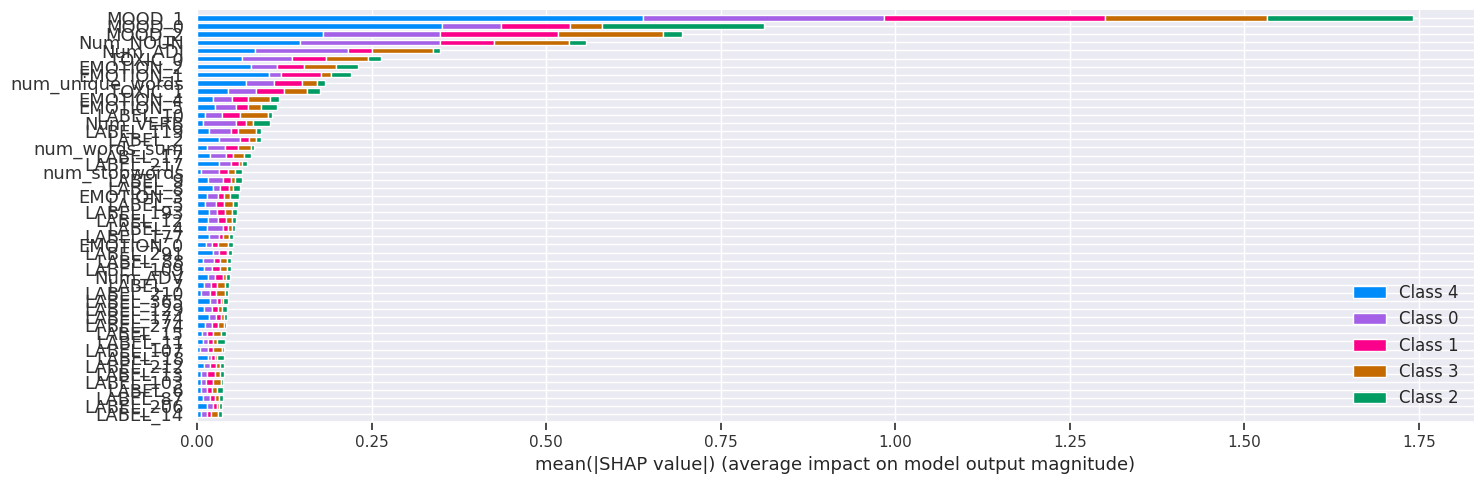

In [71]:
explainer = shap.TreeExplainer(clf)

val_dataset = Pool(data=val_split.iloc[:, 5:417], label=val_split['rate'])
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, val_split.iloc[:, 5:417], max_display = 50, plot_size = (15, 5))

Class 0


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


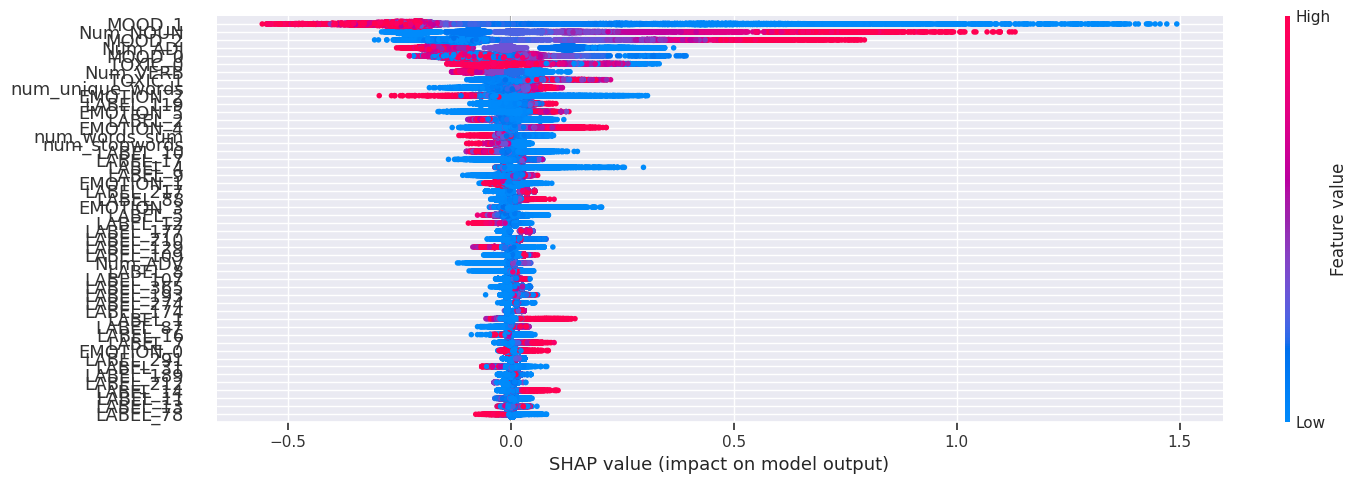

Class 1


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


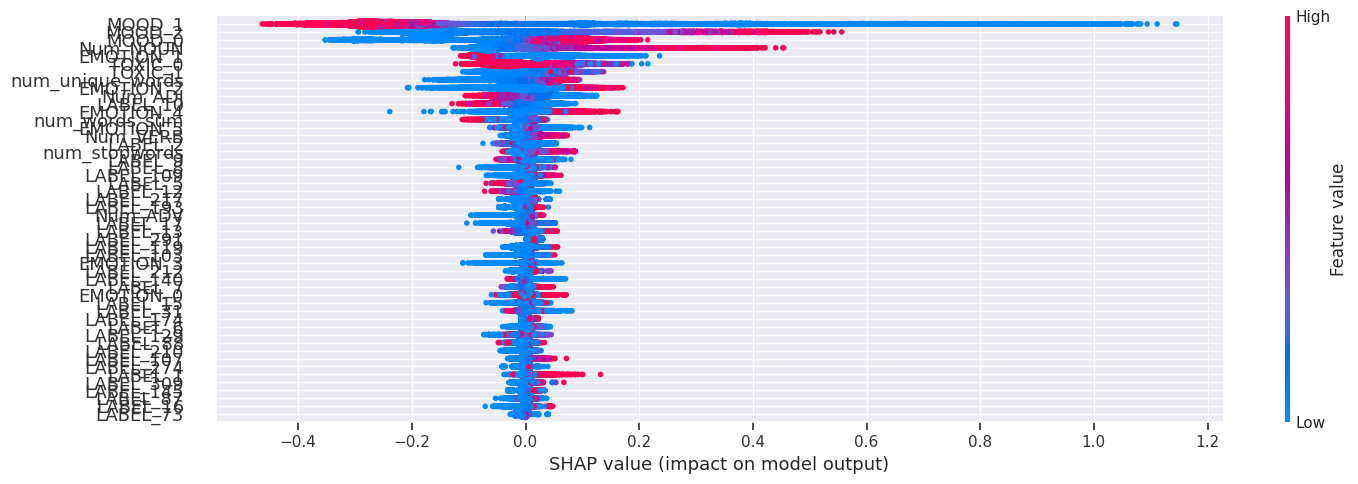

Class 2


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


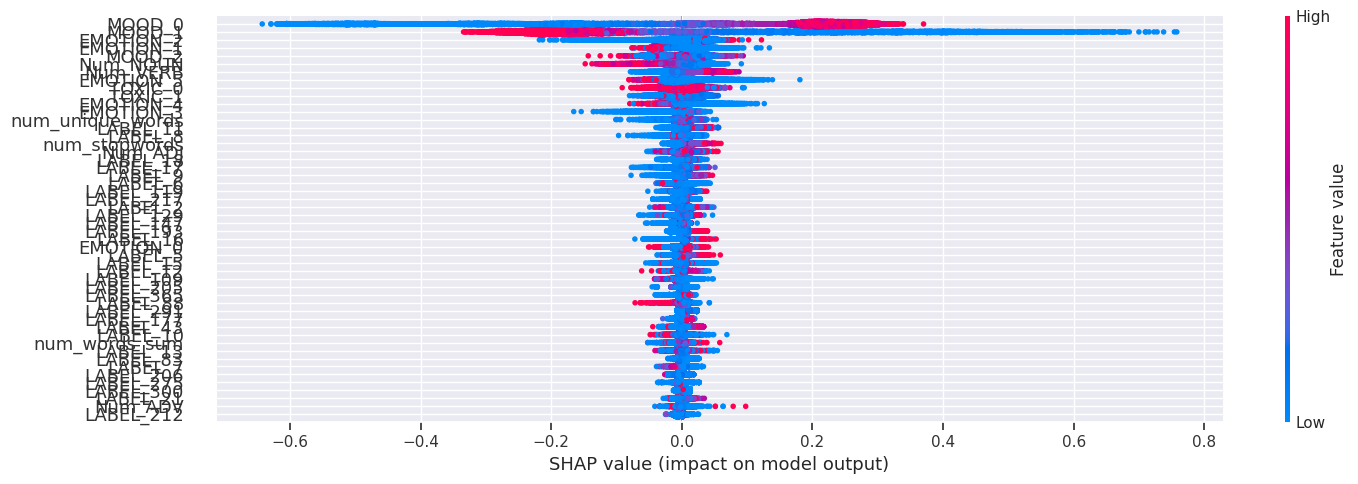

Class 3


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


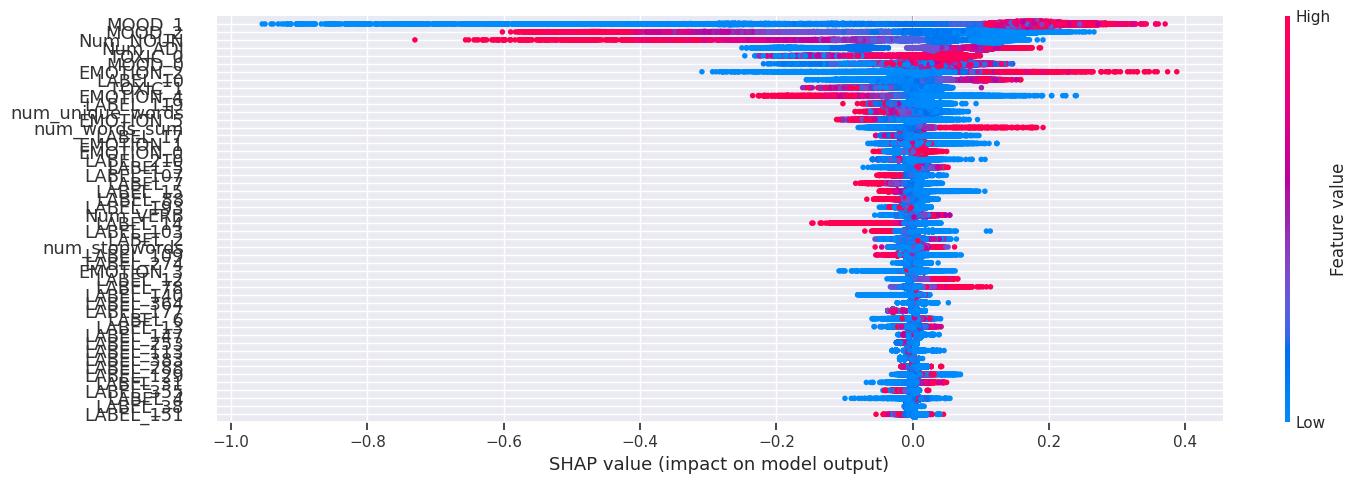

Class 4


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


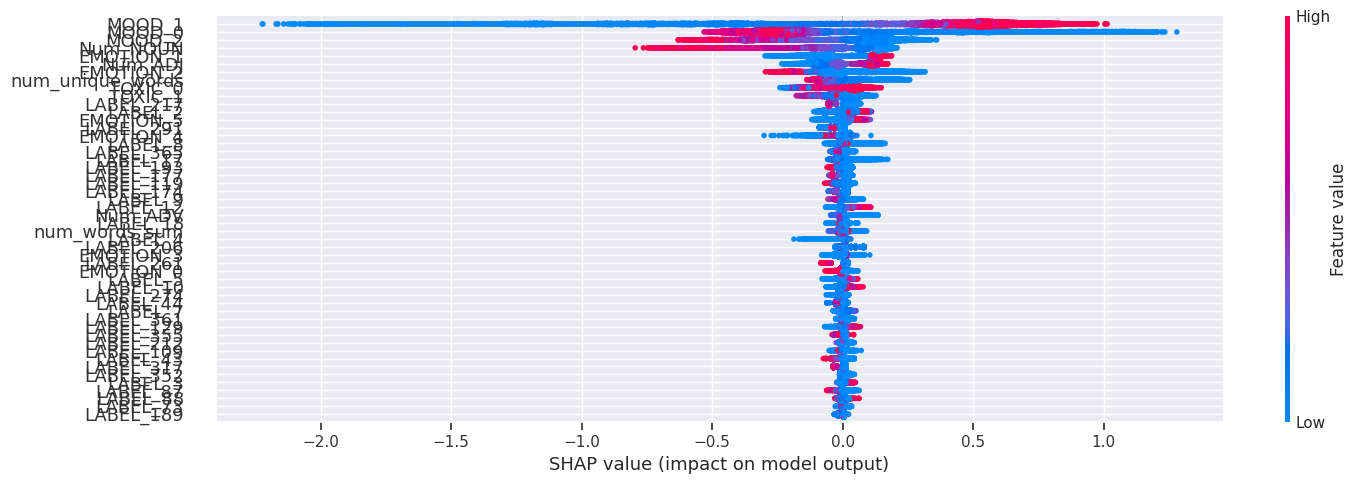

In [72]:
for i in range(len(np.unique(val_split['rate'].values))):
    print(f'Class {i}')
    shap.summary_plot(shap_values[i], val_split.iloc[:, 5:417], max_display = 50, color_bar=True, plot_size = (15, 5))

In [79]:
# !pip install boostaroota -q > installer_log.txt

from boostaroota import BoostARoota
import warnings
warnings.filterwarnings("ignore")


br = BoostARoota(metric='logloss')
br.fit(train_split.iloc[:, 5:417], train_split['rate'])
br_imp_vars = pd.DataFrame(br.keep_vars_)

[13:36:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Round:  1  iteration:  1
[13:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Round:  1  iteration:  2
[13:37:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Round:  1  iteration:  3
[13:38:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Round:  1  iteration:  4
[13:38:56] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Round:  1  iteration:  5
[13:39:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Round:  1  iteration:  6
[13:40:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Round:  1  iteration:  7
[13:40:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Round:  1  iteration:  8
[13:41:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Round:  1  iteration:  9
[13:41:41] WARNING:

TypeError: can only concatenate str (not "float") to str

# 

In [35]:
import seaborn as sns 
import matplotlib.pyplot as plt 


numeric_cols = [col for col in train_data.columns if col not in ['rate'] and train_data[col].dtype in ['float64', 'int64']]


# Import Libraries

# CLasses

In [ ]:

MAX_LEN = 50
BATCH_SIZE = 64

# Loading data

# Label encoding

# Cleaning

In [ ]:
%aimport nltk.corpus.reader.bracket_parse
%autoreload 0


In [ ]:
import plotly.express as px
def show_count_by_rate(data, rate_name = None, name = "Data"):
    fig = px.histogram(data, x="num_words", color=rate_name, title=f"Number of words in {name} by rate")
    fig.update_layout(bargap=0.2)

    fig.show()
    
show_count_by_rate(train_data, rate_name = "rate", name = 'Train_data')
show_count_by_rate(test_data, name = 'Test_data')

In [ ]:
# удалим все 0 и те, чье количество меньше 30
train_data = train_data[train_data['num_words'] != 0]
# train_data = train_data[train_data['num_words'] < 30]

# Train Test split

In [ ]:
# train_split, val_split = train_test_split(train_data[train_data['rate'] != 4], test_size=0.15, random_state=42, 
#                                           shuffle = True, stratify=train_data[train_data['rate'] != 4]['rate'])

train_split, val_split = train_test_split(train_data, test_size=0.15, random_state=42, 
                                          shuffle = True, stratify=train_data['rate'])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(train_split['rate'], bins=10, alpha=0.5, label='Train Split')
plt.hist(val_split['rate'], bins=10, alpha=0.5, label='Validation Split')

plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Rates for Train and Validation Splits')

plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_split['rate']), y=train_split['rate'])
weight_tensor = torch.FloatTensor(weights)
print(weights)

# Loading tokenizer from pretrained

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "cointegrated/rubert-tiny2", truncation=True, do_lower_case=True)

# Creating datasets and dataloaders

In [ ]:
train_dataset = FiveDataset(train_split, tokenizer, MAX_LEN)
val_dataset = FiveDataset(val_split, tokenizer, MAX_LEN)
test_dataset = FiveDataset(test_data, tokenizer, MAX_LEN)

In [ ]:
MAX_LEN = 100
BATCH_SIZE = 400

In [ ]:
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)
test_dataloader = DataLoader(test_dataset, **test_params)

# Loading pretrained model from Huggingface

In [ ]:
config = {
    "num_classes": len(np.unique(train_split['rate'])),
    "dropout_rate": 0.1
}
model = ModelForClassification(
    "cointegrated/rubert-tiny2",
    config=config
)

# Creating Trainer object and fitting the model

In [ ]:
trainer_config = {
    "lr": 3e-4,
    "n_epochs": 3,
    "weight_decay": 1e-6,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}
t = Trainer(trainer_config, class_weights=weight_tensor)
# ,class_weights=weight_tensor

In [ ]:
t.fit(
    model,
    train_dataloader,
    val_dataloader
)

# Save model

In [ ]:
t.save("best_baseline_model.ckpt")

# Load pretrained Model

In [ ]:
t = Trainer.load("best_baseline_model.ckpt")

# Get testset predictions


In [ ]:
predictions = t.predict(test_dataloader)

In [ ]:
predicted_classes = [np.argmax(probabilities) + 1 for probabilities in predictions]

# Create submission


In [ ]:
sample_submission = pd.read_csv(os.path.join(PATH, "sample_submission.csv"))
sample_submission["rate"] = predicted_classes
# sample_submission.rate = le.inverse_transform(sample_submission.rate)
sample_submission.head()

In [ ]:
sample_submission.to_csv("submission.csv", index=False)

# Train conf matrix

In [ ]:
predictions_val = t.predict(val_dataloader)

In [ ]:
predicted_classes_val = [np.argmax(probabilities) + 1 for probabilities in predictions_val]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_classification_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_classification_metrics(predicted_classes_val, le.inverse_transform(val_split['rate']), "val dataset")